In [3]:
from IPython.core.display import HTML, display
import pickle
from warnings import filterwarnings

import pymc3 as pm
import theano.tensor as tt
from theano import shared

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from seaborn import heatmap
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.ticker import FuncFormatter
from cmocean import cm as cmo

from pymc_utils import PyMCModel
from pymc_utils import evaluate_model
from pymc_utils import subset_significant_feature

In [4]:
filterwarnings('ignore', category=UserWarning)

In [5]:
display(HTML("<style>.container {width: 90% !important}</style>"))

In [6]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.minor.visible'] = True
rcParams['xtick.minor.visible'] = True
rcParams['ytick.major.size'] = 10

In [7]:
def plot_pairwise_corr(df_, ax=None, **heatmap_kwgs):
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 10))
    heatmap(df_.corr().iloc[1:,:-1],vmin=-1, vmax=1,
            mask=np.triu(np.ones([df_.shape[1]-1] * 2),k=1),
            ax=ax, **heatmap_kwgs,
            #annot=True, annot_kws={'fontsize': 10}, cmap=cmo.balance_r
           )
    ax.set_facecolor('k')
    return ax

In [8]:
def plot_fits_w_estimates(y_obs, ppc, ax=None, savename=False, steps=3):
    """ Plot Fits with Uncertainty Estimates"""
    iy  = np.argsort(y_obs)
    ix = np.arange(iy.size)
    lik_mean =ppc.mean(axis=0)
    lik_hpd = pm.hpd(ppc)
    lik_hpd_05 = pm.hpd(ppc, alpha=0.5)
    if ax is None:
        _, ax = pl.subplots(figsize=(12, 8))
    if steps > 2:
        ax.scatter(ix, y_obs.values[iy], label='observed', edgecolor='k', s=100,
                   color='steelblue', marker='d', zorder=2);
    if steps > 1:
        ax.scatter(ix, lik_mean[iy], label='model mean', edgecolor='k', s=100,
                   color='m', zorder=3)
    
    ax.fill_between(ix, y1=lik_hpd_05[iy, 0], y2=lik_hpd_05[iy, 1], color='gray', 
                   label='model output 50%CI', zorder=1,linestyle='-', lw=2, edgecolor='k');
    ax.fill_between(ix, y1=lik_hpd[iy, 0], y2=lik_hpd[iy, 1], color='k', alpha=0.75,
                   label='model output 95%CI', zorder=0, );
    ax.legend(loc='upper left');
    if savename:
        f = pl.gcf()
        f.savefig('./figJar/bayesNet/bNN_L1_nobias.pdf', format='pdf')
    return ax

In [9]:
def plot_obs_against_ppc(y_obs, ppc, ax=None, plot_1_to_1=False, **scatter_kwds):
    if ax is None:
        _, ax = pl.subplots(figsize=(10, 10))
    ppc_mean = ppc.mean(axis=0)
    mae = mean_absolute_error(y_obs, ppc_mean)
    r2 = r2_score(y_obs, ppc_mean)
    
    scatter_lbl = f'$r^2$={r2:.2f}, mae={mae:.2f}'
    scatter_lbl = scatter_kwds.pop('label', scatter_lbl)
    ax.scatter(y_obs, ppc_mean, edgecolor='k', label=scatter_lbl, **scatter_kwds)
    if plot_1_to_1:
        min_ = min(ppc_mean.min(), y_obs.min())
        max_ = max(ppc_mean.max(), y_obs.max())
        ax.plot([min_, max_], [min_, max_], ls='--', color='k', label='1:1')
    ax.legend(loc='upper left')
    return ax

In [10]:
def uncertainty_plot_2(ppc_train, ppc_test, y_test_, y_train_, ax, band_color,
                      scatter_zorder=2, hpd_zorder=0, hpd_50_zorder=1):
    ix_ = np.argsort(y_train_)
    hpd_50 = pm.hpd(ppc_train[:, ix_], alpha=0.5)
    hpd = pm.hpd(ppc_train[:, ix_],)
    mean_ = ppc_train[:, ix_].mean(axis=0)
    mean_test_ = ppc_test.mean(axis=0)
    ax.scatter(mean_test_, y_test_, edgecolor='k', lw=2, zorder=scatter_zorder, color=band_color, s=50)
    ax.fill_betweenx(mean_, x1=hpd[:, 0], x2=hpd[:, 1], alpha=0.25, zorder=hpd_zorder, color=band_color)
    ax.fill_betweenx(mean_, x1=hpd_50[:, 0], x2=hpd_50[:, 1], alpha=0.25, color=band_color)

In [11]:
ds = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
#ds['log10_aphy%d' % band] = np.log10(ds.loc[:, 'aphy%d' % band])
#ds.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [12]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [13]:
aphys = ds.filter(regex='^aphy').columns.tolist()
ds_reduced = ds.drop(aphys, axis=1,)

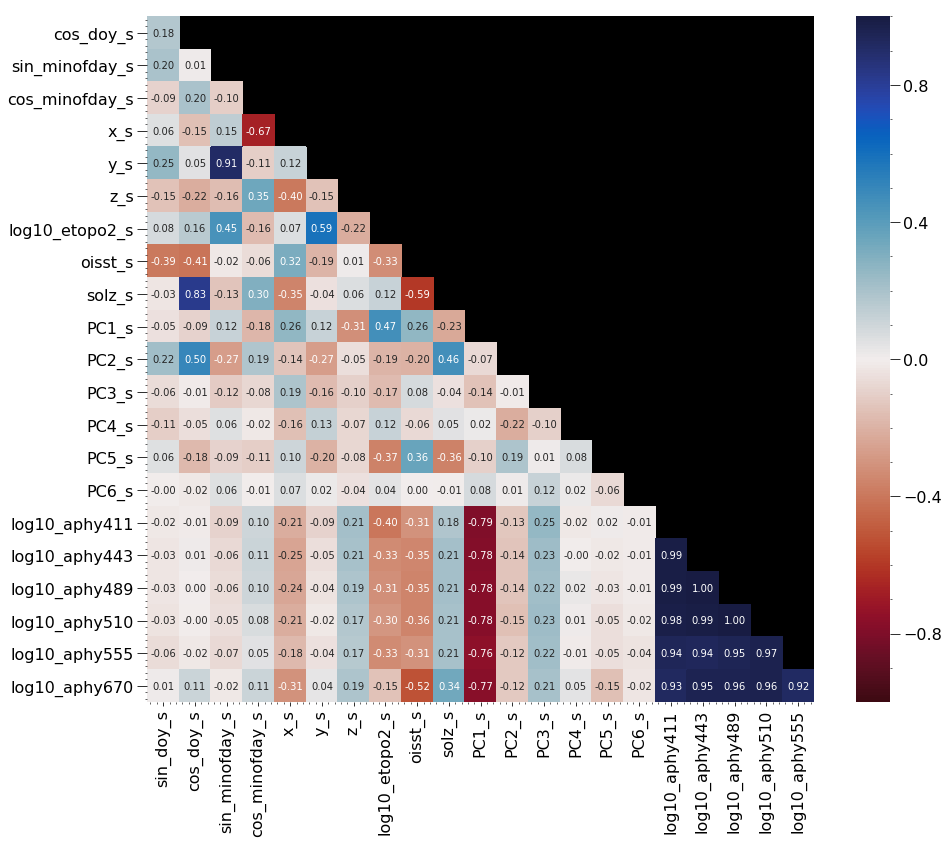

In [14]:
f, ax = pl.subplots(figsize=(14, 12))
plot_pairwise_corr(ds_reduced, ax=ax, annot=True, annot_kws=dict(fontsize=10), cmap=cmo.balance_r, fmt='.2f');
f.tight_layout()
f.savefig('/accounts/ekarakoy/WRITEUPS/TOA_ML_Writeup/FigJar/feature_heatmap_annotated.png', dpi=300)

In [15]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'

X_s = ds_reduced.dropna().loc[:, :feat_end_ni]
lbls_X_s = X_s.columns.tolist()
y = ds_reduced.dropna().filter(regex='log10_aphy')

In [16]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y, test_size=0.1,
                                                       random_state=42)
Xy_train = pd.concat((X_s_train, y_train), axis=1)

In [17]:
with open('./pickleJar/Models/BayesianBNN/Aphi_ALL_BNN_4_HL1_ARD.pkl', 'rb') as f:
    pickledModelDict = pickle.load(f)

In [18]:
bnn_l1_4HL_411 = pickledModelDict['bnn_l1_4HL_411']
bnn_l1_4HL_443 = pickledModelDict['bnn_l1_4HL_443']
bnn_l1_4HL_489 = pickledModelDict['bnn_l1_4HL_489']
bnn_l1_4HL_510 = pickledModelDict['bnn_l1_4HL_510']
bnn_l1_4HL_555 = pickledModelDict['bnn_l1_4HL_555']
bnn_l1_4HL_670 = pickledModelDict['bnn_l1_4HL_670']

### Fitting w/ All Features

####  <u>Model 1: Single Layer BNN -- 4-unit HL</u>

In [19]:
X_shared = shared(X_s_train.values)

In [20]:
# Check fit on training model
X_shared.set_value(X_s_train.values)
ppc_train_l1_411 = bnn_l1_4HL_411.predict(likelihood_name='likelihood')

#bnn_l1_4HL_411.plot_model_fits(y_train.log10_aphy411, ppc_train_l1_411, loss_metric='mae', );

100%|██████████| 2000/2000 [00:02<00:00, 718.08it/s]


In [21]:
ppc_train_l1_411.shape

(2000, 17)

In [22]:
bnn_l1_4HL_411.trace_.varnames

['hyp_w_i_1_sd_log__',
 'hyp_w_1_out_sd_log__',
 'hyp_bias_1_sd_log__',
 'wts_i_1_intrmd',
 'wts_1_o_intrmd',
 'bias_1_ordered__',
 'bias_o',
 'sd_log__',
 'hyp_w_i_1_sd',
 'hyp_w_1_out_sd',
 'hyp_bias_1_sd',
 'wts_i_1',
 'wts_1_out',
 'bias_1',
 'layer1_act',
 'out_act',
 'sd']

In [23]:
bnn_l1_4HL_555.trace_.get_values('wts_i_1').shape

(4000, 16, 4)

In [24]:
# Check Fit on Test Data
X_shared.set_value(X_s_test.values)
ppc_test_411 = bnn_l1_4HL_411.predict(likelihood_name='likelihood')
mae_test_411 = mean_absolute_error(y_test.log10_aphy411, ppc_test_411.mean(axis=0))
ppc_test_443 = bnn_l1_4HL_443.predict(likelihood_name='likelihood')
mae_test_443 = mean_absolute_error(y_test.log10_aphy443, ppc_test_443.mean(axis=0))
ppc_test_489 = bnn_l1_4HL_489.predict(likelihood_name='likelihood')
mae_test_489 = mean_absolute_error(y_test.log10_aphy489, ppc_test_489.mean(axis=0))
ppc_test_510 = bnn_l1_4HL_510.predict(likelihood_name='likelihood')
mae_test_510 = mean_absolute_error(y_test.log10_aphy510, ppc_test_510.mean(axis=0))
ppc_test_555 = bnn_l1_4HL_555.predict(likelihood_name='likelihood')
mae_test_555 = mean_absolute_error(y_test.log10_aphy555, ppc_test_555.mean(axis=0))
ppc_test_670 = bnn_l1_4HL_670.predict(likelihood_name='likelihood')
mae_test_670 = mean_absolute_error(y_test.log10_aphy670, ppc_test_670.mean(axis=0))

100%|██████████| 2000/2000 [00:02<00:00, 906.95it/s]


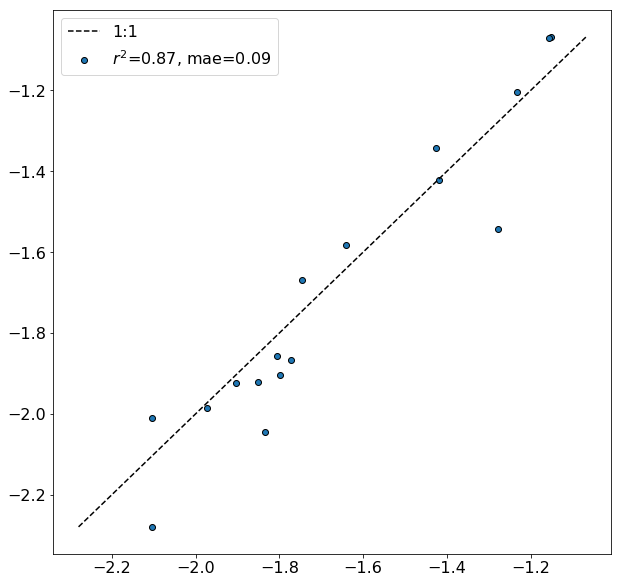

In [39]:
from matplotlib.ticker import FuncFormatter
ax1 = plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, plot_1_to_1=True)
#ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x:.2f}'))
#ax1.set_xticks([])

### A$\phi$_443

100%|██████████| 2000/2000 [00:02<00:00, 707.20it/s]


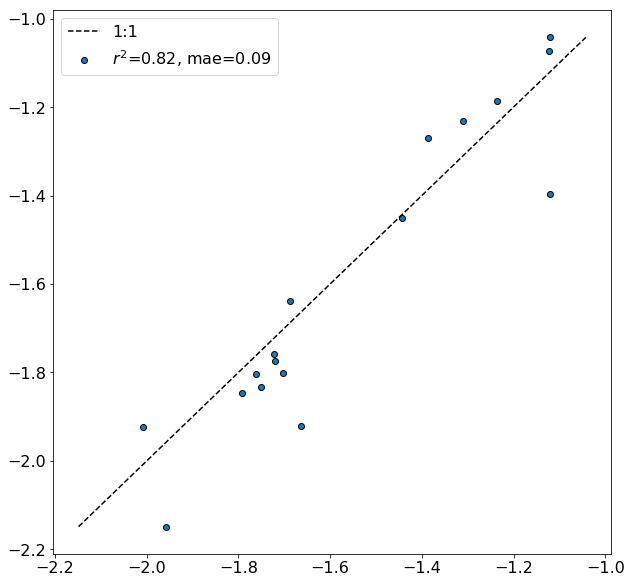

In [22]:
# Check Fit on Test Data
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, plot_1_to_1=True)

### A$\phi$_489

100%|██████████| 2000/2000 [00:02<00:00, 712.75it/s]


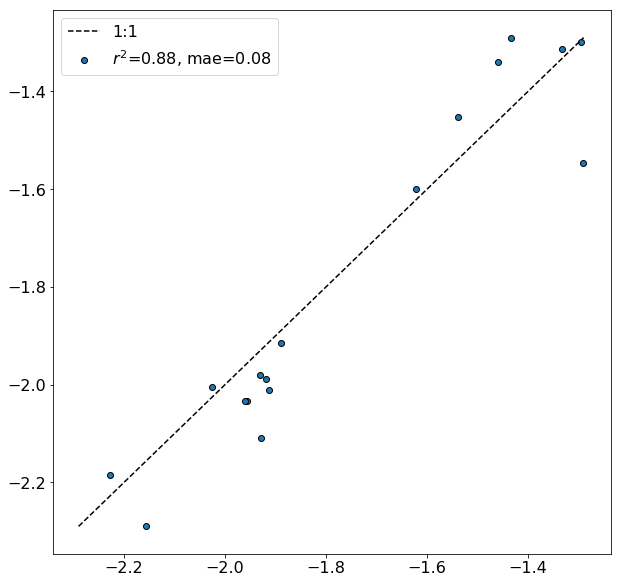

In [23]:
# Check Fit on Test Data
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, plot_1_to_1=True)

### A$\phi$_510

100%|██████████| 2000/2000 [00:02<00:00, 869.72it/s]


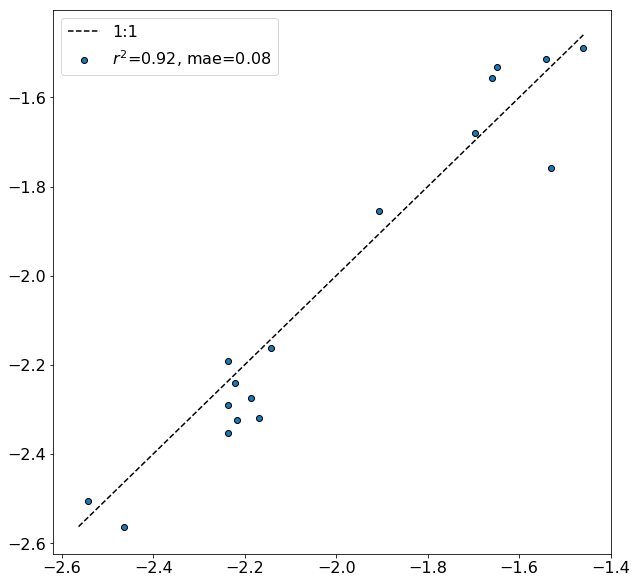

In [24]:
# Check Fit on Test Data
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, plot_1_to_1=True)

### A$\phi$555

100%|██████████| 2000/2000 [00:02<00:00, 711.16it/s]


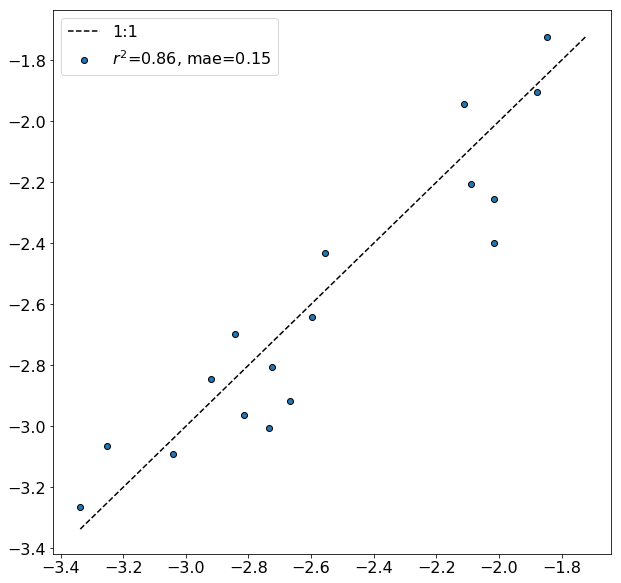

In [25]:
# Check Fit on Test Data

plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, plot_1_to_1=True)

### A$\phi$ 670

100%|██████████| 2000/2000 [00:02<00:00, 889.07it/s]


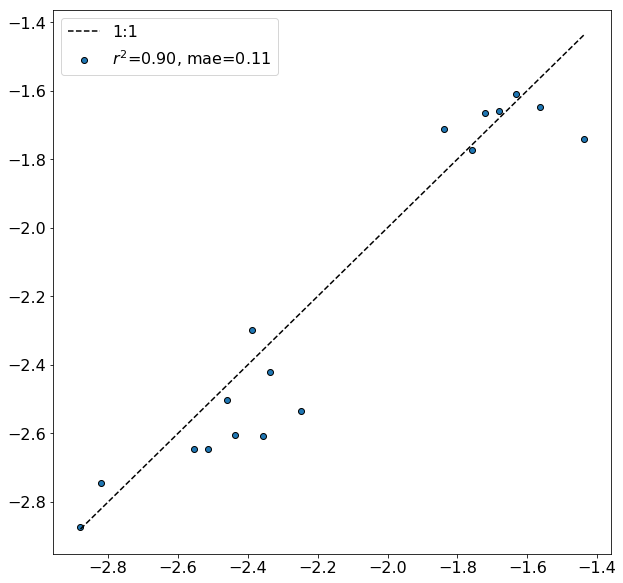

In [26]:
# Check Fit on Test Data
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, plot_1_to_1=True)

### Summary Graphs

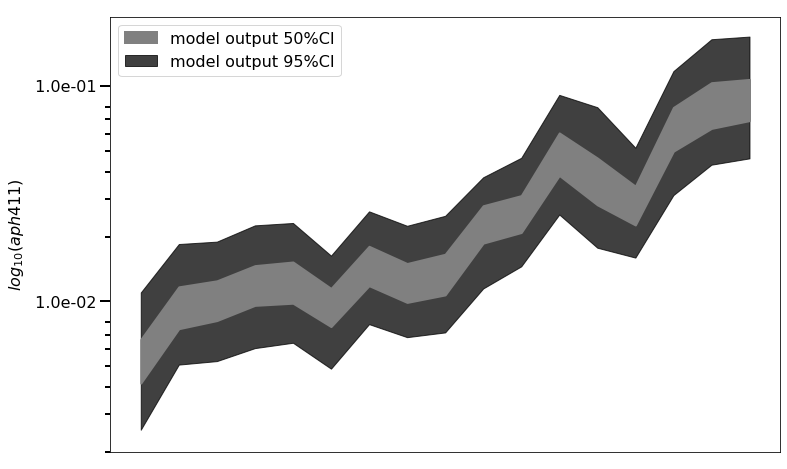

In [76]:
step=1
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411, steps=step)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
ax.set_yticks(np.log10(np.asarray([1e-2, 1e-1])))
minor_ticks = np.concatenate((np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
ax.set_yticks(np.log10(minor_ticks), minor=True)
ax.tick_params(axis='y', which='minor', length=5, width=2)
ax.tick_params(axis='y', which='major', length=10, width=2)
ax.tick_params(axis='x', which='both', length=0, width=0)
#ax.tick_params(axis='x', which=)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_411_unc_%d.pdf' % step, dpi=300, format='pdf')

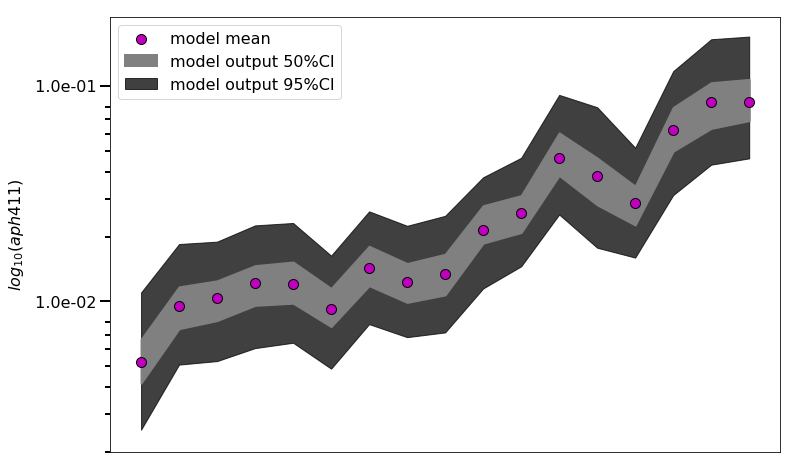

In [74]:
step=2
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411, steps=step)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
ax.set_yticks(np.log10(np.asarray([1e-2, 1e-1])))
minor_ticks = np.concatenate((np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
ax.set_yticks(np.log10(minor_ticks), minor=True)
ax.tick_params(axis='y', which='minor', length=5, width=2)
ax.tick_params(axis='y', which='major', length=10, width=2)
ax.tick_params(axis='x', which='both', length=0, width=0)
#ax.tick_params(axis='x', which=)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_411_unc_%d.pdf' % step, dpi=300, format='pdf')

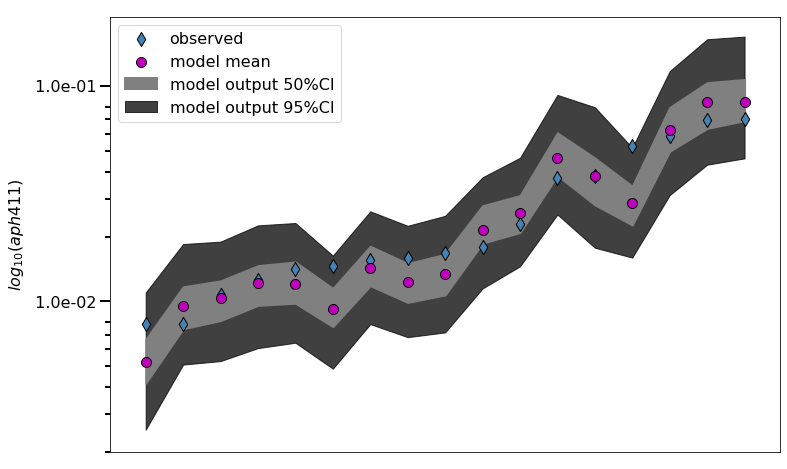

In [75]:
step=3
ax = plot_fits_w_estimates(y_test.log10_aphy411, ppc_test_411, steps=step)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 411)$')
ax.set_yticks(np.log10(np.asarray([1e-2, 1e-1])))
minor_ticks = np.concatenate((np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
ax.set_yticks(np.log10(minor_ticks), minor=True)
ax.tick_params(axis='y', which='minor', length=5, width=2)
ax.tick_params(axis='y', which='major', length=10, width=2)
ax.tick_params(axis='x', which='both', length=0, width=0)
#ax.tick_params(axis='x', which=)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_411_unc_%d.pdf' % step, dpi=300, format='pdf')

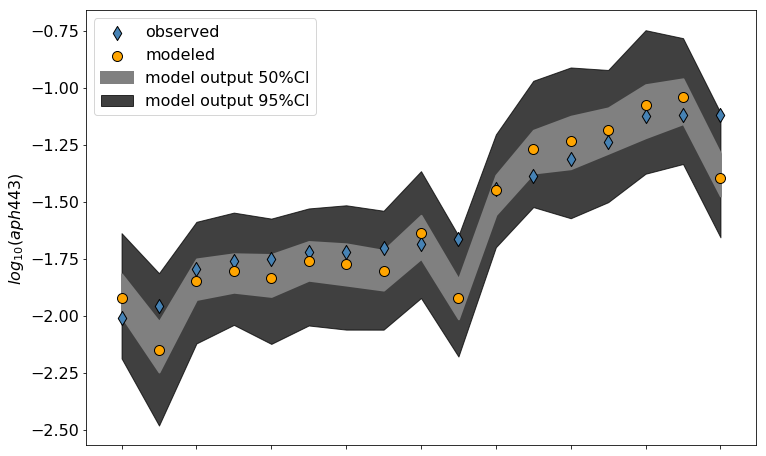

In [28]:
ax = plot_fits_w_estimates(y_test.log10_aphy443, ppc_test_443)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 443)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_443_unc.pdf', dpi=300, format='pdf')

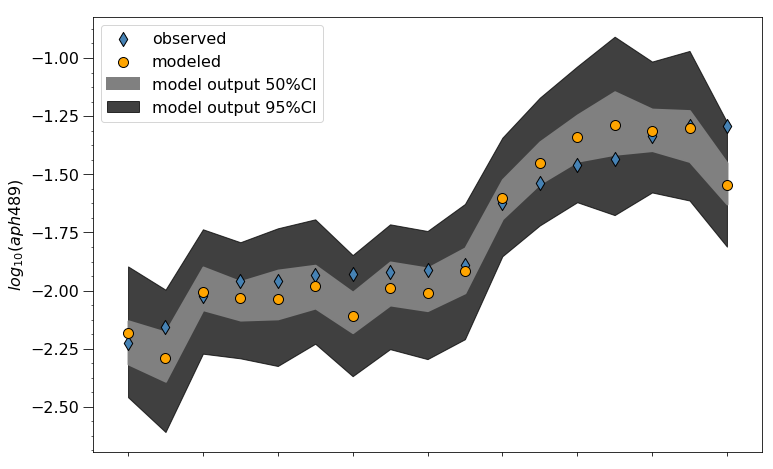

In [86]:
ax = plot_fits_w_estimates(y_test.log10_aphy489, ppc_test_489)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 489)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_489_unc.pdf', dpi=300, format='pdf')

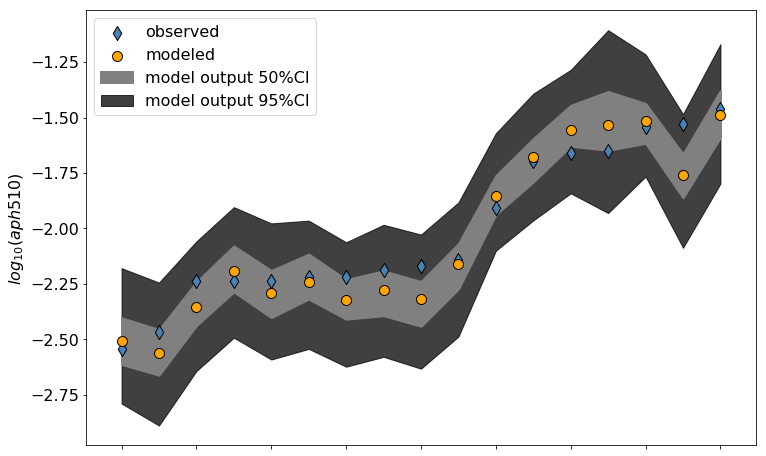

In [30]:
ax = plot_fits_w_estimates(y_test.log10_aphy510, ppc_test_510)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 510)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_510_unc.pdf', dpi=300, format='pdf')

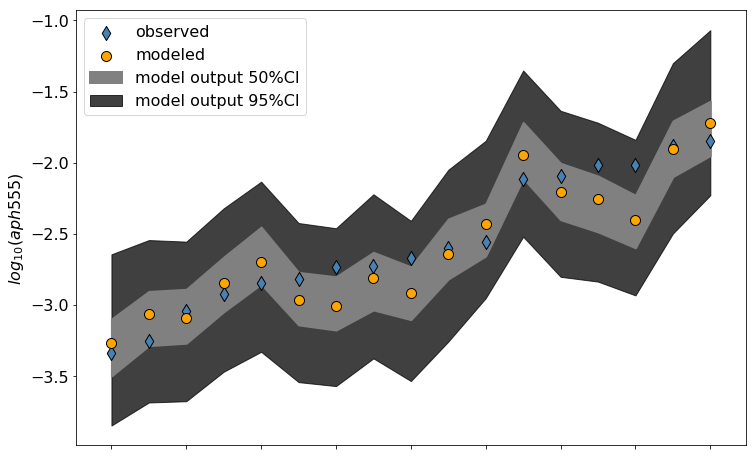

In [31]:
ax = plot_fits_w_estimates(y_test.log10_aphy555, ppc_test_555)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 555)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_555_unc.pdf', dpi=300, format='pdf')

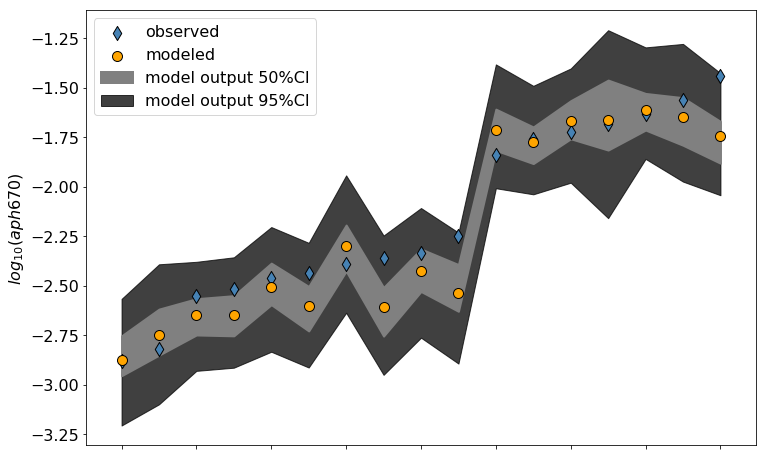

In [32]:
ax = plot_fits_w_estimates(y_test.log10_aphy670, ppc_test_670)
ax.set_xticklabels([]);
ax.set_ylabel('$log_{10}(aph 670)$')
f = pl.gcf()
f.savefig('./figJar/Single_HL_4_aphi_670_unc.pdf', dpi=300, format='pdf')

In [26]:
minor_ticks = np.concatenate((np.arange(5e-4, 9e-4, 1e-4), np.arange(2e-3, 9e-3, 1e-3), np.arange(2e-2, 9e-2, 1e-2)))
f, ax_ = pl.subplots(figsize=(10, 10))
plot_obs_against_ppc(y_test.log10_aphy411, ppc_test_411, color='m', label='aph411; mae=%.2f' % mae_test_411, s=75, ax=ax_) 
plot_obs_against_ppc(y_test.log10_aphy443, ppc_test_443, color='steelblue', ax=ax_, label='aph443; mae=%.2f' % mae_test_443, s=75,)
plot_obs_against_ppc(y_test.log10_aphy489, ppc_test_489, color='cyan', ax=ax_, label='aph489; mae=%.2f' % mae_test_489, s=75, )
plot_obs_against_ppc(y_test.log10_aphy510, ppc_test_510, color='orange', ax=ax_, label='aph510; mae=%.2f' % mae_test_510, s=75,)
plot_obs_against_ppc(y_test.log10_aphy555, ppc_test_555, color='brown', ax=ax_, label='aph555; mae=%.2f' % mae_test_555, s=75, )
plot_obs_against_ppc(y_test.log10_aphy670, ppc_test_670, color='red', ax=ax_, label='aph670; mae=%.2f' % mae_test_670, s=75, )
ax_.plot([-3.4, -1], [-3.4, -1], color='k', ls='--')
ax_.legend()
ax_.set_xlabel('model output mean')
ax_.set_ylabel('observed')
ax_.set_yticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_xticks(np.log10(np.asarray([1e-3, 1e-2, 1e-1])))
ax_.set_yticks(np.log10(minor_ticks), minor=True)
ax_.set_xticks(np.log10(minor_ticks), minor=True)
ax_.tick_params(axis='both', which='minor', length=5, width=2)
ax_.tick_params(axis='both', which='major', length=10, width=2)
ax_.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
ax_.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{10**x: .1e}'))
f.tight_layout()
f.savefig('./figJar/Single_HL_4_aphi_test_sets.pdf', format='pdf', dpi=300)